# Hierarchical Clustering Analysis

In [ ]:
# Let's start with some packages we need
from __future__ import print_function
import torch
import torch.nn as nn
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
import re
import string
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

In [ ]:
# Read the contents of the text file
with open("data/NCE2.txt", "r") as file:
    text = file.read()
    
def remove_non_ascii(s):
    return re.sub(r'[^\x00-\x7F]+|\d|&', '', s)

# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Splitting the text into sentences
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s|\n', text)
sentences = [remove_non_ascii(item) for item in sentences]
print(sentences)

In [ ]:
# Preprocessing function
def preprocess(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove punctuation
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    # Tokenize the sentence
    words = sentence.split()
    # Lemmatize the words considering their POS tags
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# Applying the preprocessing function to each sentence
preprocessed_sentences = [preprocess(sentence) for sentence in sentences]
sentences_tokens = [['<SOS>']+s+['<EOS>'] for s in preprocessed_sentences]
print(sentences_tokens)

In [ ]:
unique_tokens = sorted(set(sum(sentences_tokens,[])))
# print(unique_tokens)

def sentenceToTensor(tokens_list):
    # Convert list of strings to tensor of token indices (integers)
    #
    # Input
    #  tokens_list : list of strings, e.g. ['<SOS>','lion','eat','man','<EOS>']
    # Output
    #  1D tensor of the same length (integers), e.g., tensor([ 2, 18, 13, 19,  0])
    assert(isinstance(tokens_list,list))
    tokens_index = [token_to_index[token] for token in tokens_list]
    return torch.tensor(tokens_index)

n_tokens = len(unique_tokens) # all words and special tokens
token_to_index = {t : i for i,t in enumerate(unique_tokens)}
index_to_token = {i : t for i,t in enumerate(unique_tokens)}
training_pats = [sentenceToTensor(s) for s in sentences_tokens] # python list of 1D sentence tensors
ntrain = len(training_pats)
print('mapping unique tokens to integers: %s \n' % token_to_index)
print('example sentence as string: %s \n' % ' '.join(sentences_tokens[0]))
print('example sentence as tensor: %s \n' % training_pats[0])

print(unique_tokens)

### RNN Architecture


In [ ]:
class SRN(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        # vocab_size : number of tokens in vocabulary including special tokens <SOS> and <EOS>
        # hidden_size : dim of input embeddings and hidden layer
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size,hidden_size)
        # TODO : YOUR CODE GOES HERE
        self.fc1 = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=0)
        # raise Exception('Replace with your code.')

    def forward(self, input_token_index, hidden_prev):
        # Input
        #    input_token_index: [integer] index of current input tokens
        #    hidden_prev: [length hidden_size 1D tensor] hidden state from previous step
        # Outpuut
        #    output: [length vocab_size 1D tensor] log-probability of emitting each output token
        #    hidden_curr : [length hidden_size 1D tensor] hidden state for current step
    
        input_embed = self.embed(input_token_index) # hidden_size 1D tensor
        
        input_combined = torch.cat((input_embed, hidden_prev), 0) #previous hidden states + input_embed
        hidden_curr = self.sigmoid(self.fc1(input_combined))
        output = self.softmax(self.fc2(hidden_curr))

        # raise Exception('Replace with your code.')
        return output, hidden_curr

    def initHidden(self):
        # Returns length hidden_size 1D tensor of zeros
        return torch.zeros(self.hidden_size)
    
    def get_embeddings(self):
        # Returns [vocab_size x hidden_size] numpy array of input embeddings
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

### Training

In [60]:
def train(seq_tensor, rnn):
    # Process a sentence and update the SRN weights. With <SOS> as the input at step 0,
    # predict every subsequent word given the past words.
    # Return the mean loss across each symbol prediction.
    #
    # Input
    #   seq_tensor: [1D tensor] sentence as token indices
    #   rnn : instance of SRN class
    # Output
    #   loss : [scalar] average NLL loss across prediction steps
    # TODO : YOUR CODE GOES HERE
    # 定义梯度裁剪阈值
    clip_value = 1.0
    
    hidden = rnn.initHidden()
    rnn.train()
    rnn.zero_grad()
    loss = 0
    seq_length = seq_tensor.shape[0]

    for i in range(seq_length - 1):
        output, hidden = rnn(seq_tensor[i], hidden)
        loss += criterion(output, seq_tensor[i+1]) 
    loss.backward()
    
    # grad_norm = 0
    # for p in rnn.parameters():
    #     if p.grad is not None:
    #         grad_norm += p.grad.data.norm(2).item()
    # grad_norm = grad_norm ** 0.5
    # print(f"Gradient norm: {grad_norm}")
    
     # 对梯度进行裁剪
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip_value)
    optimizer.step()

    return loss.item() / float(seq_length-1)
    # raise Exception('Replace with your code.')

In [62]:
# Main training loop
nepochs = 50 # number of passes through the entire training set 
nhidden = 20 # number of hidden units in the SRN
rnn = SRN(n_tokens,nhidden)
optimizer = torch.optim.AdamW(rnn.parameters(), weight_decay=0.04) # w/ default learning rate 0.001
criterion = nn.NLLLoss()

for i in range(nepochs):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+1} is: {error_epoch}")
# raise Exception('Replace with your code.')

loss for epoch 1 is: 5.912179321804785
loss for epoch 2 is: 5.3628547650069365
loss for epoch 3 is: 5.25639391365713
loss for epoch 4 is: 5.173107493026819
loss for epoch 5 is: 5.084677913625382
loss for epoch 6 is: 4.996124918399211
loss for epoch 7 is: 4.9107850272041365
loss for epoch 8 is: 4.830719090975124
loss for epoch 9 is: 4.753794840376251
loss for epoch 10 is: 4.683395884203897
loss for epoch 11 is: 4.613389976409399
loss for epoch 12 is: 4.550378832460072
loss for epoch 13 is: 4.489347377115565
loss for epoch 14 is: 4.4326377638854755
loss for epoch 15 is: 4.379089639556071
loss for epoch 16 is: 4.326496205494814
loss for epoch 17 is: 4.284211193560002
loss for epoch 18 is: 4.23122230036463
loss for epoch 19 is: 4.194125275298086
loss for epoch 20 is: 4.152139331451823
loss for epoch 21 is: 4.114963722392867
loss for epoch 22 is: 4.0800244720503125
loss for epoch 23 is: 4.045468899419214
loss for epoch 24 is: 4.015978500947707
loss for epoch 25 is: 3.987723417713075
loss fo

In [63]:
for i in range(20):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+51} is: {error_epoch}")
# raise Exception('Replace with your code.')

loss for epoch 51 is: 3.567387441253734
loss for epoch 52 is: 3.562214718293782
loss for epoch 53 is: 3.552611543703556
loss for epoch 54 is: 3.5467823023778253
loss for epoch 55 is: 3.538385248475277
loss for epoch 56 is: 3.5307398599466646
loss for epoch 57 is: 3.5237495630220117
loss for epoch 58 is: 3.5155120995613736
loss for epoch 59 is: 3.5119168109389856
loss for epoch 60 is: 3.501646030564078
loss for epoch 61 is: 3.5018144222195895
loss for epoch 62 is: 3.490232992743481
loss for epoch 63 is: 3.487534890810137
loss for epoch 64 is: 3.4787055262316073
loss for epoch 65 is: 3.474375424430301
loss for epoch 66 is: 3.4674598284749663
loss for epoch 67 is: 3.4643391661608818
loss for epoch 68 is: 3.4586726296185133
loss for epoch 69 is: 3.453563154624032
loss for epoch 70 is: 3.449492987093196


In [69]:
for i in range(30):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+71} is: {error_epoch}")
# raise Exception('Replace with your code.')

loss for epoch 71 is: 3.4424145424658517
loss for epoch 72 is: 3.437579482388836
loss for epoch 73 is: 3.436528884173241
loss for epoch 74 is: 3.429689329950653
loss for epoch 75 is: 3.426843437017119
loss for epoch 76 is: 3.4211488857423906
loss for epoch 77 is: 3.418312945807308
loss for epoch 78 is: 3.414799665286172
loss for epoch 79 is: 3.408559932671979
loss for epoch 80 is: 3.405334395082766
loss for epoch 81 is: 3.4003384122664047
loss for epoch 82 is: 3.4026270456197074
loss for epoch 83 is: 3.3947904673514184
loss for epoch 84 is: 3.3906878318894615
loss for epoch 85 is: 3.3877439955342337
loss for epoch 86 is: 3.3842317193687395
loss for epoch 87 is: 3.3822838604071035
loss for epoch 88 is: 3.3782204301674037
loss for epoch 89 is: 3.3757587864751057
loss for epoch 90 is: 3.3731407788377563
loss for epoch 91 is: 3.3671138353899295
loss for epoch 92 is: 3.365810287425494
loss for epoch 93 is: 3.360174674269506
loss for epoch 94 is: 3.3620811862468356
loss for epoch 95 is: 3.35

In [72]:
torch.save(rnn.state_dict(), 'weights/100_epochs_clipped_weights.pth')

In [73]:
for i in range(50):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+101} is: {error_epoch}")
# raise Exception('Replace with your code.')

loss for epoch 101 is: 3.3412683594834554
loss for epoch 102 is: 3.339655004231356
loss for epoch 103 is: 3.338534433734587
loss for epoch 104 is: 3.3357967517953178
loss for epoch 105 is: 3.3330112521687685
loss for epoch 106 is: 3.3309175381252025
loss for epoch 107 is: 3.3273709033832533
loss for epoch 108 is: 3.325990574812757
loss for epoch 109 is: 3.323331648356362
loss for epoch 110 is: 3.323625961615833
loss for epoch 111 is: 3.3195783971385744
loss for epoch 112 is: 3.3175669626146274
loss for epoch 113 is: 3.316582696658131
loss for epoch 114 is: 3.3140112190557667
loss for epoch 115 is: 3.3111240320214925
loss for epoch 116 is: 3.31006342177852
loss for epoch 117 is: 3.3104999842528233
loss for epoch 118 is: 3.305625914599676
loss for epoch 119 is: 3.304653869775097
loss for epoch 120 is: 3.302264131017262
loss for epoch 121 is: 3.303582331821966
loss for epoch 122 is: 3.2985205819834893
loss for epoch 123 is: 3.296936734296015
loss for epoch 124 is: 3.296700456210218
loss f

In [74]:
torch.save(rnn.state_dict(), 'weights/150_epochs_clipped_weights.pth')

In [ ]:
# Create a new model with the same architecture
loaded_model = SRN(n_tokens,nhidden)

# Load the saved weights into the new model
loaded_model.load_state_dict(torch.load('weights/100_epochs_lemmatized_weights.pth'))

# Set the model to evaluation mode
loaded_model.eval()

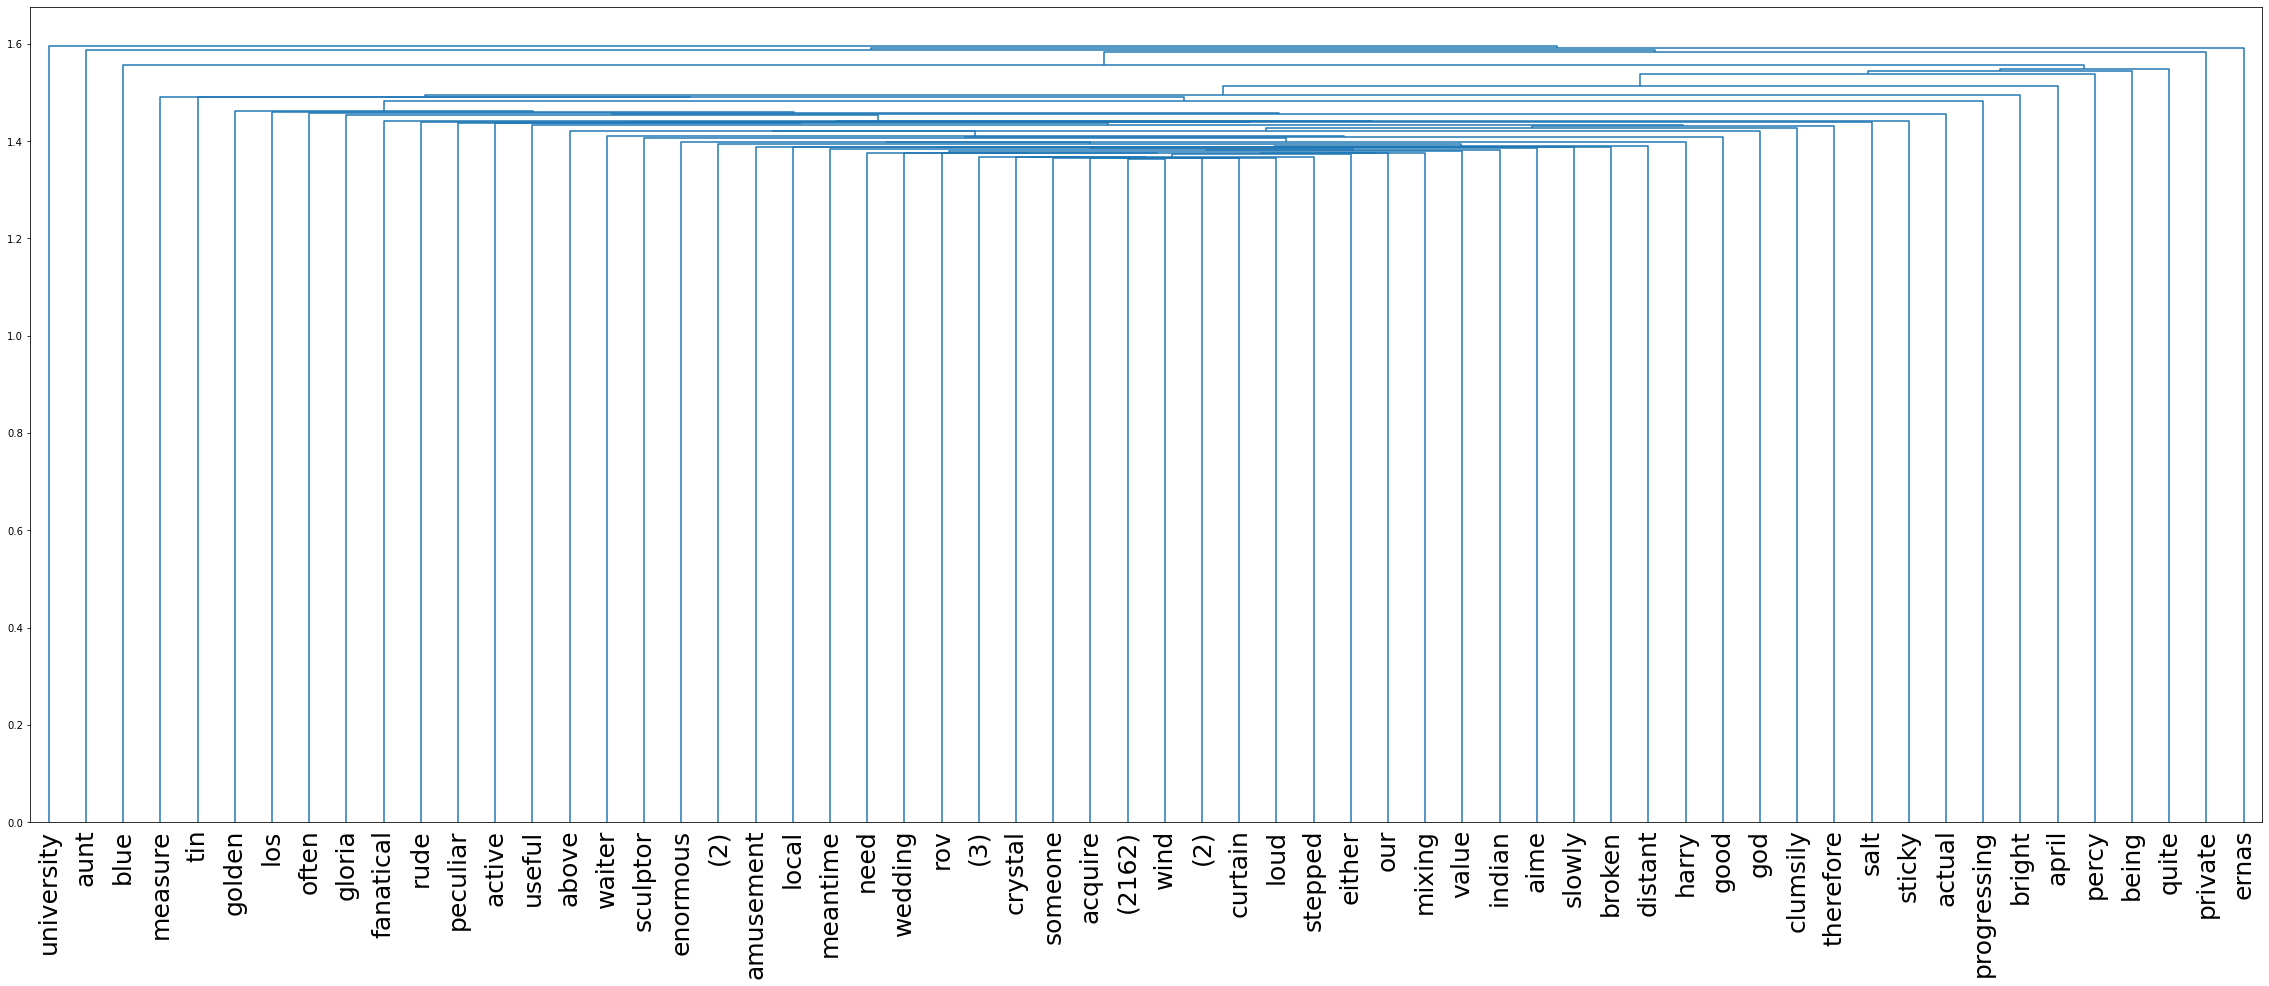

In [75]:
def plot_dendo(X, names, exclude=['<SOS>','<EOS>']):
    #  Show hierarchical clustering of vectors 
    #
    # Input
    #  X : numpy tensor [nitem x dim] such that each row is a vector to be clustered
    #  names : [length nitem] list of item names
    #  exclude: list of names we want to exclude       
    nitem = len(names)
    names  = np.array(names)
    include = np.array([myname not in exclude for myname in names], dtype=bool)
    linked = linkage(X[include],'single', optimal_ordering=True)
    plt.figure(figsize=(40,15))
    
    # truncate to show only 50 high level clusters
    n_clusters = 60
    dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=25, truncate_mode='lastp', p=n_clusters)
    # dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=8)
    plt.show()
    
    # plt.savefig("word_embeddings_dendrogram.png", dpi=300, bbox_inches='tight')

plot_dendo(rnn.get_embeddings(), unique_tokens)

### Generate outputs

In [76]:
def generate(rnn, maxlen=20):
    # TODO : YOUR CODE GOES HERE
    # concat = torch.cat((special_token, prob_tensor),0)

    with torch.no_grad():
        output = torch.tensor(1) # assume it starts with <SOS>
        hidden = rnn.initHidden()
        res = [index_to_token[output.item()]]
        for i in range(maxlen):
            output, hidden = rnn(output, hidden)
            m = torch.distributions.categorical.Categorical(torch.exp(output))
            output = m.sample()
            res.append(index_to_token[output.item()])
            if output.item() == 0:
                break
            
        print(" ".join(res))
# raise Exception('Replace with your code.')
    
for i in range(20):
    generate(loaded_model)

<SOS> the cause patient answered <EOS>
<SOS> im special mountain but nearly fell it always the telephone now <EOS>
<SOS> i had come into a special capsule <EOS>
<SOS> last it wa now fireman leave mr thompson had been a lot and men taking him <EOS>
<SOS> the whole too cause need in reluctant to note sorry contained him difficult your we had come to length and
<SOS> i never our long very hard and it is that difficult i had after sent will be held a rude
<SOS> <EOS>
<SOS> are placed into the station for long very floor then is only year and he could very these tree <EOS>
<SOS> when none of shepenmut who had waited <EOS>
<SOS> lesson a letter my wife come his one voice immediately harry been sing <EOS>
<SOS> we by one just she wa flown confidence <EOS>
<SOS> when the aeroplane began so <EOS>
<SOS> when they so i past pedestal carried inside some microphone are read in first bill london <EOS>
<SOS> she said to he had thing at the next aircraft <EOS>
<SOS> i have so paint when even a hole ha